In [1]:
import import_ipynb

In [2]:
%run iteration_0_imports.py

In [3]:
%run iteration_0_parameters.py

In [4]:
import iteration_0_utils as utils

importing Jupyter notebook from iteration_0_utils.ipynb


In [5]:
%whos

Variable                          Type        Data/Info
-------------------------------------------------------
HEALTHY                           str         H
IMG_IN_COLOR                      int         1
IMG_SIZE                          int         64
Image                             module      <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
NBR_SAMPLE                        int         20000
PATH_DATA                         str         ../data
PATH_DATA_EDA                     str         ../data/eda
PATH_DATA_LIST                    str         ../data/list
PATH_DATA_SAMPLE                  str         ../data/sample
PATH_MODEL                        str         ../model
PATH_ROOT                         str         ..
PATH_SOURCE_IMG                   str         ../cell_images
RandomForestClassifier            ABCMeta     <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SICK                              str         S
classification_report             function

# make X, y

In [6]:
DATE_TIME = "2021-11-18_20-39-00"

In [7]:
# get list 
list_path_sample_img = []
list_path_sample_img.extend(glob.glob(PATH_DATA_SAMPLE+"/"+DATE_TIME+ "/"+ "*.pklz"))

In [8]:
# split train, validation, test set
list_path_sample_img_train, list_path_sample_img_test  = train_test_split(list_path_sample_img, test_size=0.2)
list_path_sample_img_train, list_path_sample_img_valid = train_test_split(list_path_sample_img_train, test_size=0.2)

In [9]:
def make_Xy(list_path_sample_img: list) -> (np.array, np.array):
    X = np.ndarray( (len(list_path_sample_img), IMG_SIZE, IMG_SIZE, 3) ,dtype = "float16")
    y = np.array([""] * len(list_path_sample_img))
    for i, path in tqdm(enumerate(list_path_sample_img)):
        
        X[i] = utils.pickle_read(path).astype("float16")
    
        _, file_name, _ = utils.split_file_info(path)
        y[i] = file_name[0]
    
    return X, y
    

In [10]:
X_train, y_train  = make_Xy(list_path_sample_img_train)

12800it [00:12, 1036.73it/s]


In [11]:
X_valid, y_valid  = make_Xy(list_path_sample_img_valid)

3200it [00:02, 1240.31it/s]


In [12]:
X_test, y_test  = make_Xy(list_path_sample_img_test)

4000it [00:03, 1235.21it/s]


# model_cnn

* Ref: https://towardsdatascience.com/detecting-malaria-with-deep-learning-9e45c1e34b60
* https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d

In [13]:
BATCH_SIZE = 500
NUM_CLASSES = 2
EPOCHS = 15
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [14]:
# Encoder y
from sklearn.preprocessing import LabelEncoder

In [15]:
le = LabelEncoder()

In [16]:
y_train_enc = le.fit_transform(y_train)

In [17]:
y_valid_enc = le.transform(y_valid)
y_test_enc  = le.transform(y_test)

In [18]:
le.classes_

array(['H', 'S'], dtype='<U1')

In [19]:
#!pip uninstall tensorflow

Créer un fichier .reg avec les instructions suivantes :

===

Windows Registry Editor Version 5.00

[HKEY_LOCAL_MACHINE\SYSTEM\CurrentControlSet\Control\FileSystem]
"LongPathsEnabled"=dword:00000001

---

Exécuter le .reg

In [20]:
#!pip install tensorflow

In [21]:
import tensorflow as tf

In [22]:
from keras.models import Sequential

In [23]:
#assert False

In [24]:
model_cnn = Sequential()
model_cnn.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
model_cnn.add(tf.keras.layers.Conv2D(name = "conv2D",
                                     filters=32,
                                     kernel_size=(3,3),
                                     activation="LeakyReLU",
                                     padding="same",
                                     kernel_initializer="he_uniform"
                                    ))
model_cnn.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))
model_cnn.add(tf.keras.layers.Flatten(name="flatten"))
model_cnn.add(tf.keras.layers.Dense(name="dense_hidden", units = 256, activation="LeakyReLU",
                                    kernel_initializer="he_uniform" ))
model_cnn.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))


In [25]:
# compiler modele
model_cnn.compile(optimizer = "adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [26]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_hidden (Dense)        (None, 256)               8388864   
                                                                 
 ouput (Dense)               (None, 1)                 257       
                                                                 
Total params: 8,390,017
Trainable params: 8,390,017
Non-trainable params: 0
_________________________________________________________________


In [27]:
from keras.callbacks import EarlyStopping

In [28]:
# es = EarlyStopping(mode='min', monitor='val_loss')

In [29]:
history = model_cnn.fit(X_train, y_train_enc, epochs=EPOCHS, validation_data=(X_valid, y_valid_enc), batch_size = BATCH_SIZE,
                        )

Epoch 1/15
26/26 [==============================] - 20s 771ms/step - loss: 7.3847 - accuracy: 0.5305 - val_loss: 2.4257 - val_accuracy: 0.5475
Epoch 2/15
26/26 [==============================] - 20s 758ms/step - loss: 1.1580 - accuracy: 0.5869 - val_loss: 0.6678 - val_accuracy: 0.6478
Epoch 3/15
26/26 [==============================] - 20s 774ms/step - loss: 0.6038 - accuracy: 0.6944 - val_loss: 0.5863 - val_accuracy: 0.7134
Epoch 4/15
26/26 [==============================] - 20s 758ms/step - loss: 0.5532 - accuracy: 0.7286 - val_loss: 0.5720 - val_accuracy: 0.7156
Epoch 5/15
26/26 [==============================] - 20s 754ms/step - loss: 0.5387 - accuracy: 0.7404 - val_loss: 0.5673 - val_accuracy: 0.7191
Epoch 6/15
26/26 [==============================] - 19s 744ms/step - loss: 0.5364 - accuracy: 0.7370 - val_loss: 0.5656 - val_accuracy: 0.7256
Epoch 7/15
26/26 [==============================] - 19s 738ms/step - loss: 0.5461 - accuracy: 0.7239 - val_loss: 0.5645 - val_accuracy: 0.7244

In [30]:
history.history

{'loss': [7.384681224822998,
  1.1580359935760498,
  0.6037726402282715,
  0.5531564950942993,
  0.5387405157089233,
  0.5364094972610474,
  0.5460623502731323,
  0.5283384919166565,
  0.5086095929145813,
  0.5090916752815247,
  0.5005897283554077,
  0.4704243540763855,
  0.4762183129787445,
  0.4632304906845093,
  0.46737149357795715],
 'accuracy': [0.530468761920929,
  0.5868750214576721,
  0.6943749785423279,
  0.7285937666893005,
  0.7403905987739563,
  0.7369531393051147,
  0.7239062786102295,
  0.7440624833106995,
  0.7638280987739563,
  0.7532031536102295,
  0.7587500214576721,
  0.7932031154632568,
  0.7825781106948853,
  0.7938281297683716,
  0.78125],
 'val_loss': [2.425722360610962,
  0.6677753925323486,
  0.5863196849822998,
  0.5719549059867859,
  0.5672568678855896,
  0.5656003355979919,
  0.5644923448562622,
  0.588542640209198,
  0.5713697671890259,
  0.561215341091156,
  0.5593048334121704,
  0.5934865474700928,
  0.5587794780731201,
  0.5643130540847778,
  0.584471583

In [31]:
print(model_cnn.metrics_names)

['loss', 'accuracy']


In [32]:
def plot_history(history):
    plt.figure(figsize=(16,9))
    # plot loss
    plt.subplot(211)
    plt.grid()
    plt.title('binary_crossentropy')
    plt.plot(history.history['loss'], "o-", color='blue', label='train')
    plt.plot(history.history['val_loss'], "o-", color='orange', label='validation')
    plt.legend()    
    # plot accuracy
    plt.subplot(212)
    plt.grid()
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], "o-",color='blue', label='train')
    plt.plot(history.history['val_accuracy'], "o-",color='orange', label='validation')
    plt.legend()
    plt.show()

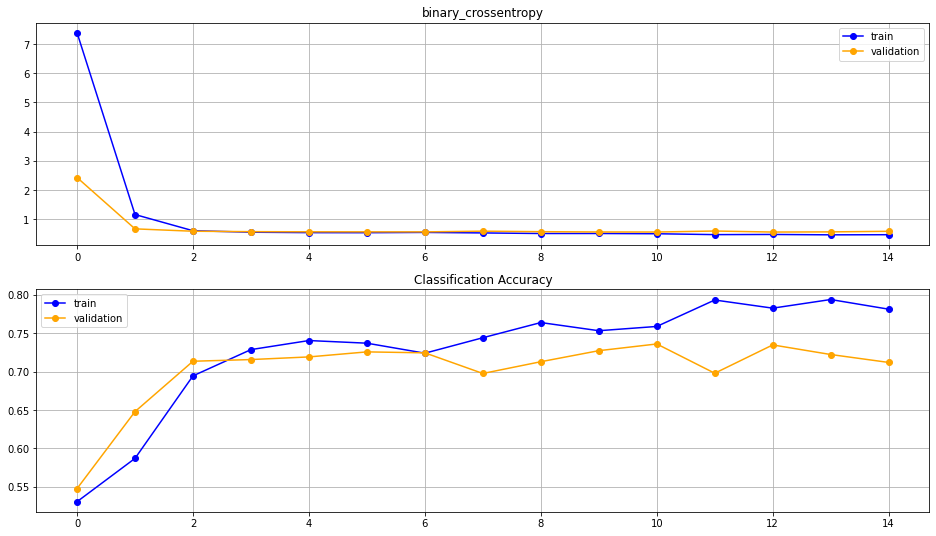

In [33]:
plot_history(history)

In [34]:
model_cnn_2 = Sequential()
model_cnn_2.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
model_cnn_2.add(tf.keras.layers.Conv2D(name = "conv2D",
                                     filters=32,
                                     kernel_size=(3,3),
                                     activation="LeakyReLU",
                                     padding="same",
                                     kernel_initializer="he_uniform"
                                    ))
model_cnn_2.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))
model_cnn_2.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                     filters=64,
                                     kernel_size=(3,3),
                                     activation="LeakyReLU",
                                     padding="same",
                                     kernel_initializer="he_uniform"
                                    ))
model_cnn_2.add(tf.keras.layers.MaxPooling2D(name="pooling_2", pool_size=(2,2)))
model_cnn_2.add(tf.keras.layers.Flatten(name="flatten"))
model_cnn_2.add(tf.keras.layers.Dense(name="dense_hidden", units = 256, activation="LeakyReLU",
                                    kernel_initializer="he_uniform" ))
model_cnn_2.add(tf.keras.layers.Dense(name="dense_hidden_2", units = 128, activation="LeakyReLU",
                                    kernel_initializer="he_uniform" ))
model_cnn_2.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))


In [35]:
# compiler modele
model_cnn_2.compile(optimizer = "adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [36]:
model_cnn_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense_hidden (Dense)        (None, 256)               4194560   
                                                                 
 dense_hidden_2 (Dense)      (None, 128)              

In [37]:
X_train.shape

(12800, 64, 64, 3)

In [38]:
history_2 = model_cnn_2.fit(X_train, y_train_enc, epochs=EPOCHS, validation_data=(X_valid, y_valid_enc), batch_size = BATCH_SIZE,
                        )

Epoch 1/15
26/26 [==============================] - 37s 1s/step - loss: 2.3516 - accuracy: 0.5265 - val_loss: 0.7214 - val_accuracy: 0.5297
Epoch 2/15
26/26 [==============================] - 40s 2s/step - loss: 0.6458 - accuracy: 0.6181 - val_loss: 0.6392 - val_accuracy: 0.6322
Epoch 3/15
26/26 [==============================] - 44s 2s/step - loss: 0.6025 - accuracy: 0.6786 - val_loss: 0.5880 - val_accuracy: 0.6988
Epoch 4/15
26/26 [==============================] - 44s 2s/step - loss: 0.5755 - accuracy: 0.7061 - val_loss: 0.6122 - val_accuracy: 0.6806
Epoch 5/15
26/26 [==============================] - 43s 2s/step - loss: 0.5777 - accuracy: 0.6932 - val_loss: 0.5857 - val_accuracy: 0.7006
Epoch 6/15
26/26 [==============================] - 41s 2s/step - loss: 0.5365 - accuracy: 0.7335 - val_loss: 0.5502 - val_accuracy: 0.7278
Epoch 7/15
26/26 [==============================] - 39s 1s/step - loss: 0.5172 - accuracy: 0.7406 - val_loss: 0.5788 - val_accuracy: 0.7050
Epoch 8/15
26/26 [==

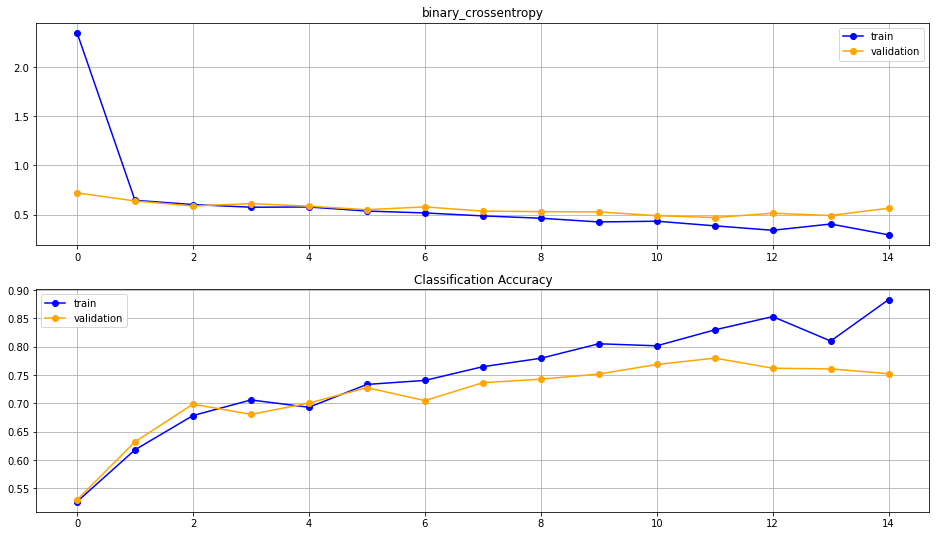

In [39]:
plot_history(history_2)

In [40]:
model_cnn_2.save(PATH_MODEL + "/model_cnn_2")

INFO:tensorflow:Assets written to: ../model/model_cnn_2\assets


INFO:tensorflow:Assets written to: ../model/model_cnn_2\assets


In [41]:
#assert False

In [42]:
# modele article

In [43]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [44]:

model_cnn_3 = Sequential()
model_cnn_3.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))

model_cnn_3.add(tf.keras.layers.Conv2D(name = "conv2D",
                                       filters=32,
                                       kernel_size=(3,3),
                                       activation="relu",
                                       padding="same",
                                       ))
model_cnn_3.add(tf.keras.layers.MaxPooling2D(name="pooling",
                                             pool_size=(2,2)
                                            ))
model_cnn_3.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                       filters=64,
                                       kernel_size=(3,3),
                                       activation="relu",
                                       padding="same",
                                       ))
model_cnn_3.add(tf.keras.layers.MaxPooling2D(name="pooling_2",
                                             pool_size=(2,2)
                                            ))
model_cnn_3.add(tf.keras.layers.Conv2D(name="conv2D_3",
                                       filters=128,
                                       kernel_size=(3,3),
                                       activation="relu",
                                       padding="same",
                                      ))
model_cnn_3.add(tf.keras.layers.MaxPooling2D(name="pooling_3",
                                             pool_size=(2,2)
                                            ))
model_cnn_3.add(tf.keras.layers.Flatten(name="flatten"))
model_cnn_3.add(tf.keras.layers.Dense(name="dense_hidden",
                                      units = 512,
                                      activation="relu",
                                     ))
model_cnn_3.add(tf.keras.layers.Dropout(name="drop_1",
                                      rate=0.3,                                      
                                     ))
model_cnn_3.add(tf.keras.layers.Dense(name="dense_hidden_2",
                                      units = 512,
                                      activation="relu",
                                     ))
model_cnn_3.add(tf.keras.layers.Dropout(name="drop_2",
                                      rate=0.3,                                      
                                     ))
model_cnn_3.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))

In [45]:
# compiler modele
model_cnn_3.compile(optimizer = "adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [46]:
model_cnn_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 conv2D_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 pooling_3 (MaxPooling2D)    (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [47]:
history_3 = model_cnn_3.fit(X_train, y_train_enc,
                            epochs=EPOCHS, validation_data=(X_valid, y_valid_enc),
                            batch_size = BATCH_SIZE
                           )

Epoch 1/25
200/200 [==============================] - 51s 255ms/step - loss: 0.6751 - accuracy: 0.5649 - val_loss: 0.5649 - val_accuracy: 0.7072
Epoch 2/25
200/200 [==============================] - 51s 253ms/step - loss: 0.2248 - accuracy: 0.9173 - val_loss: 0.1706 - val_accuracy: 0.9478
Epoch 3/25
200/200 [==============================] - 50s 252ms/step - loss: 0.1423 - accuracy: 0.9555 - val_loss: 0.1454 - val_accuracy: 0.9525
Epoch 4/25
200/200 [==============================] - 53s 264ms/step - loss: 0.1263 - accuracy: 0.9609 - val_loss: 0.1456 - val_accuracy: 0.9500
Epoch 5/25
200/200 [==============================] - 51s 257ms/step - loss: 0.1115 - accuracy: 0.9645 - val_loss: 0.1353 - val_accuracy: 0.9525
Epoch 6/25
200/200 [==============================] - 50s 248ms/step - loss: 0.0968 - accuracy: 0.9681 - val_loss: 0.2088 - val_accuracy: 0.9397
Epoch 7/25
200/200 [==============================] - 50s 252ms/step - loss: 0.0836 - accuracy: 0.9719 - val_loss: 0.1657 - val_ac

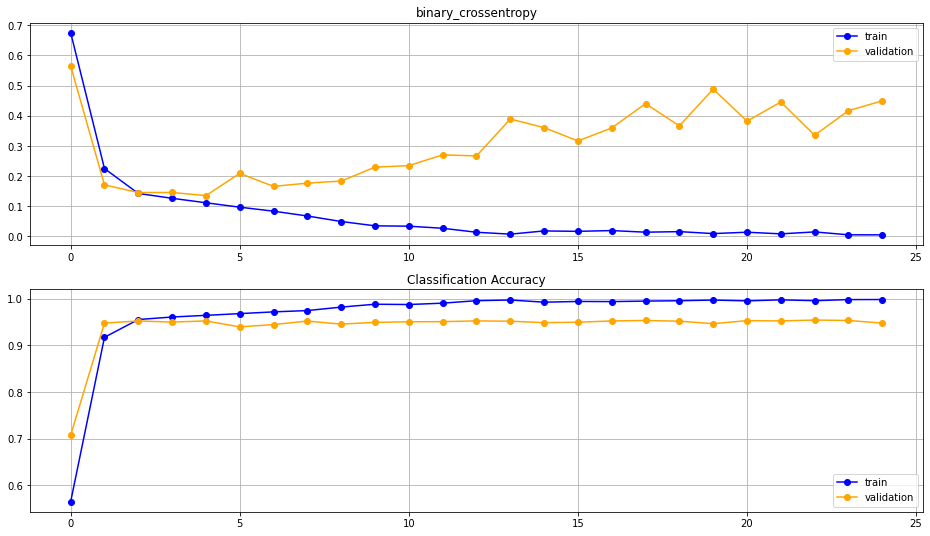

In [48]:
plot_history(history_3)

Keras avec GPU AMD
https://medium.com/@Vatsal410/keras-without-nvidia-gpus-with-plaidml-and-amd-gpu-4ba6f60025ce